In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
#El objetivo de este proyecto es encontrar las variables que expliquen o determinen el precio de venta de las propiedades del dataframe.

# Exploración de los datos y "data cleaning"

In [3]:
df=pd.read_csv('train.csv')

In [4]:
#Se puede observar con el "head" que el dataframe original cuenta con 81 variables o columnas. Se inicia un proceso de analizar los datos y quitar variables para que el dataframe quede más paqueño y con variables que afectan al valor del precio de venta de la propiedad. 
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Se revisará las columnas que tienen datos nulos:
nulls_cols=df.isnull().sum()

In [6]:
nulls_cols[nulls_cols>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
#la variable "LotFrontage" hace referencia a la medida en pies de calle conectados con la propiedad, entonces las propiedades que tienen dato nulo en esta variable es porque no están conectados con la calle. Entonces se podría cambiar a cero los valores nulos.
df['LotFrontage'] = df['LotFrontage'].fillna(0)

In [8]:
#La variable "Alley" hace referencia al tipo de acceso a la entrada trasera de la propiedad, si es de grava, pavimentada o no tiene. Entonces se podría modificar la variable para que sea categórica con variable igual a 1 (si tiene entrada trasera) ó 0 (si no tiene entrada trasera).
df['Alley'] = df['Alley'].fillna(0)
df['Alley'] = df['Alley'].replace(['Grvl'],1)
df['Alley'] = df['Alley'].replace(['Pave'],1)

In [9]:
#La variable "MasVnrType" hace referencia a la mampostería (ladrillo, piedra, etc.) de la propiedad, los 8 registros que tienen dato nulo podrían ser cambiados a la opción "None".
df['MasVnrType'] = df['MasVnrType'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].replace([0],'None')

In [10]:
#La variable "MasVnrArea" hace referencia a la área de revestimiento de mampostería en pies cuadrados. los 8 registros que tienen dato nulo podrían ser cambiados a 0.
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['MasVnrArea'] = df['MasVnrArea'].replace([0],'None')

In [11]:
#La variable "BsmtQual" hace referencia a la altura del sótano de la propiedad, entonces los registros con dato nulo son las propiedades sin sótano. Se podría convetir la variable en categórica con valor 1 (si tiene sótano) y 0 (no tiene sótano).
df['BsmtQual'] = df['BsmtQual'].fillna(0)
df['BsmtQual'] = df['BsmtQual'].replace(['TA'],1)
df['BsmtQual'] = df['BsmtQual'].replace(['Gd'],1)
df['BsmtQual'] = df['BsmtQual'].replace(['Ex'],1)
df['BsmtQual'] = df['BsmtQual'].replace(['Fa'],1)

In [12]:
df['BsmtQual'].value_counts()

1    1423
0      37
Name: BsmtQual, dtype: int64

In [13]:
#La variable "BsmtCond" hace referencia a la condición del sótano de la propiedad. Podemos quitar esta variable porque ya tendríamos a la variable "BsmtQual" que nos dira si afecta o no tener sótano para el precio de la propiedad.
del df['BsmtCond']

In [14]:
#La variable "BsmtExposure" también se podría eliminar porque tmb hace referencia al sótano y ya con la variable "BsmtQual" se revisa si afecta la existencia o no del sótano en el precio de la propiedad.
del df['BsmtExposure']

In [15]:
#La variable "BsmtFinType1" también se podría eliminar porque tmb hace referencia al sótano y ya con la variable "BsmtQual" se revisa si afecta la existencia o no del sótano en el precio de la propiedad.
del df['BsmtFinType1']

In [16]:
#La variable "BsmtFinType2" también se podría eliminar porque tmb hace referencia al sótano y ya con la variable "BsmtQual" se revisa si afecta la existencia o no del sótano en el precio de la propiedad.
del df['BsmtFinType2']

In [17]:
#La variable "Electrical" hace referencia al sistema eléctrico de la propiedad. El unico registro con variable nula se puede cambiar a la categoría con mayor número de observaciones. El cambio de un registro no cambiará los resultados porque existen 1,460 observaciones.

In [18]:
df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [19]:
#Se cambia el registro con variable nula de "Electrical" a SBrkr que hace referencia a circuito eléctrico estándar B&R.
df['Electrical'] = df['Electrical'].fillna(0)
df['Electrical'] = df['Electrical'].replace([0],'SBrkr')

In [20]:
df['Electrical'].value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [21]:
#se cambiará la variable "Electrical" a numérica.
df['Electrical']=df['Electrical'].replace(['SBrkr'],0)
df['Electrical']=df['Electrical'].replace(['FuseA'],1)
df['Electrical']=df['Electrical'].replace(['FuseF'],2)
df['Electrical']=df['Electrical'].replace(['FuseP'],3)
df['Electrical']=df['Electrical'].replace(['Mix'],4)
df['Electrical'].value_counts()

0    1335
1      94
2      27
3       3
4       1
Name: Electrical, dtype: int64

In [22]:
#La variable "FireplaceQu" hace referencia a la calidad de las chimeneas en la propiedad. Esta variable podría eliminarse ya que existe una variable "Fireplaces" que hace referencia al número de chimeneas en la propiedad, por lo que ya se está estimando si las chimeneas afectan al precio de la propiedad.
del df['FireplaceQu']

In [23]:
#La variable "GarageType" hace referencia al lugar del garage en la propiedad (adjunto a la propiedad, en el sótano, a parte, etc.). Por lo que se podría modificar la variable a una variable binaria donde tendría el valor de 1 (si cuenta con garage) y 0 (si no cuenta con garage) para ver si afecta la presencia de garage al precio de la propiedad.
df['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [24]:
df['GarageType'] = df['GarageType'].fillna(0)
df['GarageType'] = df['GarageType'].replace(['Attchd'],1)
df['GarageType'] = df['GarageType'].replace(['Detchd'],1)
df['GarageType'] = df['GarageType'].replace(['BuiltIn'],1)
df['GarageType'] = df['GarageType'].replace(['Basment'],1)
df['GarageType'] = df['GarageType'].replace(['CarPort'],1)
df['GarageType'] = df['GarageType'].replace(['2Types'],1)
df['GarageType'].value_counts()

1    1379
0      81
Name: GarageType, dtype: int64

In [25]:
#Las variables "GarageYrBlt", "GarageFinish", "GarageQual" y "GarageCond" se pueden eliminar ya que la variable "GarageType" tomará en cuenta si contar con un garage afecta al percio de la propiedad.
del df['GarageYrBlt']
del df['GarageFinish']
del df['GarageQual']
del df['GarageCond']

In [26]:
#Se pueden eliminar el resto de variables relacionadas a las características del garage de la propiedad porque para fines del proyecto solo me interesa saber si el contar o no con garage efecta al precio de venta de las propiedades. 
del df['GarageCars']
del df['GarageArea']

In [27]:
#La variable "PoolQC" hace referencia a la calidad de la alberca. Se podría cambiar a auna variable binaria donde tome el valor 1 (tiene alberca) y 0 (no cuenta con alberca) para analizar si afecta el contar con alberca al precio de la propiedad. Asimismo se podría eliminar la variable "PoolArea" ya que ya se tendría una variable que toma en cuenta la existencia de alberca para nalizar si afecta en el precio.
df['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [28]:
#Solo hay 7 propiedades de 1,460 propiedades con alberca, por lo que se puede eleminar tanto la variable "PoolQC" como la variable "PoolArea" porque no es muy representativo el hecho de tener alberca en la muestra.
del df['PoolQC']
del df['PoolArea']

In [29]:
#La variable "Fence" hace referencia a la calidad de la reja o barda. Se podría cambiar a una variable binaria donde tome el valor 1 (cuando la propiedad tenga barda) y 0 (cuando la propiedad no tenga barda) para analizar si afecta el contar con barda al precio de la propiedad. 
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [30]:
df['Fence'] = df['Fence'].fillna(0)
df['Fence'] = df['Fence'].replace(['MnPrv'],1)
df['Fence'] = df['Fence'].replace(['GdPrv'],1)
df['Fence'] = df['Fence'].replace(['GdWo'],1)
df['Fence'] = df['Fence'].replace(['MnWw'],1)
df['Fence'].value_counts()

0    1179
1     281
Name: Fence, dtype: int64

In [31]:
#La variable "MiscFeature" hace referencia a si la propiedad cuenta con una característica especial como elevador, un segundo garage, cancha de tennis, etc. Se podría cambiar esta variable a una variable binaria donde tome el valor de 1 (cuando la propiedad tenga una característica espacial) y 0 (cuando la propiedad no tenga características especiales).
df['MiscFeature'].value_counts()

Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

In [32]:
df['MiscFeature'] = df['MiscFeature'].fillna(0)
df['MiscFeature'] = df['MiscFeature'].replace(['Shed'],1)
df['MiscFeature'] = df['MiscFeature'].replace(['Gar2'],1)
df['MiscFeature'] = df['MiscFeature'].replace(['Othr'],1)
df['MiscFeature'] = df['MiscFeature'].replace(['TenC'],1)
df['MiscFeature'].value_counts()

0    1406
1      54
Name: MiscFeature, dtype: int64

In [33]:
#Checando nuevamente valores nulos, para ver si todavía hay o ya no existen
nulls_cols=df.isnull().sum()
nulls_cols[nulls_cols>0]

Series([], dtype: int64)

In [34]:
#Se podría eliminar la variable "Condition2" porque ya existe la variable "Condition1", estas variables indican la proximidad a diversas condiciones como a arterias principales, calles normales, vías de ferrocarril, etc. Entonces con sólo tener una vriable que tenga en cuenta este efecto, es suficiente, no veo necesario contar con dos variables por si existen más de una de estas condiciones. 
del df['Condition2']

In [35]:
#se cambiarán las variables que están definidas como objeto, para que todas las variables sean numéricas y sea más fácil trabajar con ellas y observar las relaciones que existen entre ellas.

In [36]:
pd.options.display.max_rows = 999

In [37]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley              int64
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea        object
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual           int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object
CentralAir        object
Electrical         int64
1stFlrSF           int64
2ndFlrSF           int64


In [38]:
#se cambiará la variable "MSZoning" a numérica, la cual identifica la clasificación general de la zona de la venta. Quedará de la siguiente manera: Agriculture=0, Commercial=1, Floating Village Residential=2, Industrial=3, Residential High Density=4, Residential Low Density=5, Residential Low Density Park=6, Residential Medium Density=7.
df['MSZoning'] = df['MSZoning'].replace(['A'],0)
df['MSZoning'] = df['MSZoning'].replace(['C (all)'],1)
df['MSZoning'] = df['MSZoning'].replace(['FV'],2)
df['MSZoning'] = df['MSZoning'].replace(['I'],3)
df['MSZoning'] = df['MSZoning'].replace(['RH'],4)
df['MSZoning'] = df['MSZoning'].replace(['RL'],5)
df['MSZoning'] = df['MSZoning'].replace(['RP'],6)
df['MSZoning'] = df['MSZoning'].replace(['RM'],7)
df['MSZoning'].value_counts()

5    1151
7     218
2      65
4      16
1      10
Name: MSZoning, dtype: int64

In [39]:
#se cambiará la variable "Street" a numérica, la cual identifica la clasificación de la calle de la entrada de la propiedad. Quedará de la siguiente manera: Gravel=0, Paved=1.
df['Street'] = df['Street'].replace(['Grvl'],0)
df['Street'] = df['Street'].replace(['Pave'],1)
df['Street'].value_counts()

1    1454
0       6
Name: Street, dtype: int64

In [40]:
#se cambiará la variable "LotShape" a numérica, la cual identifica la clasificación de la forma general de la propiedad. Quedará de la siguiente manera: Regular=0, Slightly irregular=1, Moderately irregular=2, Irregular=3.
df['LotShape']=df['LotShape'].replace(['Reg'],0)
df['LotShape']=df['LotShape'].replace(['IR1'],1)
df['LotShape']=df['LotShape'].replace(['IR2'],2)
df['LotShape']=df['LotShape'].replace(['IR3'],3)
df['LotShape'].value_counts()

0    925
1    484
2     41
3     10
Name: LotShape, dtype: int64

In [41]:
#se cambiará la variable "LandContour" a numérica, la cual identifica la clasificación de lo plano de la propiedad. Quedará de la siguiente manera: Cerca a plano=0, Elevación significativa del nivel de la calle=1, Ladera-pendiente significativa de lado a lado=2, Hundido=3.
df['LandContour']=df['LandContour'].replace(['Lvl'],0)
df['LandContour']=df['LandContour'].replace(['Bnk'],1)
df['LandContour']=df['LandContour'].replace(['HLS'],2)
df['LandContour']=df['LandContour'].replace(['Low'],3)
df['LandContour'].value_counts()

0    1311
1      63
2      50
3      36
Name: LandContour, dtype: int64

In [42]:
#se eleminirá la variable "Utilities", la cual identifica la clasificación de los servicios públicos disponibles en la propiedad. Se elimina la variable porque de la muestra todas las casas tienen todos los servicios menos una, por lo que la muestra no sirve para analizar el efecto de tener o no los servicios públicos. 
del df['Utilities']


In [43]:
#se cambiará la variable "LotConfig" a numérica, la cual identifica la clasificación de la configuración de la propiedad. Quedará de la siguiente manera: interna=0, esquina=1, cul-de-sac=2, fachada en dos lados=3 y fachada en tres lados=4.
df['LotConfig']=df['LotConfig'].replace(['Inside'],0)
df['LotConfig']=df['LotConfig'].replace(['Corner'],1)
df['LotConfig']=df['LotConfig'].replace(['CulDSac'],2)
df['LotConfig']=df['LotConfig'].replace(['FR2'],3)
df['LotConfig']=df['LotConfig'].replace(['FR3'],4)
df['LotConfig'].value_counts()

0    1052
1     263
2      94
3      47
4       4
Name: LotConfig, dtype: int64

In [44]:
#se cambiará la variable "LandSlope" a numérica, la cual identifica la clasificación de la pendiente de la propiedad. Quedará de la siguiente manera: Gentil=0, Moderada=1, Severa=2.
df['LandSlope']=df['LandSlope'].replace(['Gtl'],0)
df['LandSlope']=df['LandSlope'].replace(['Mod'],1)
df['LandSlope']=df['LandSlope'].replace(['Sev'],2)
df['LandSlope'].value_counts()

0    1382
1      65
2      13
Name: LandSlope, dtype: int64

In [45]:
#se cambiará la variable "Neighborhood" a numérica, la cual identifica la colonia de la propiedad. 
df['Neighborhood']=df['Neighborhood'].replace(['Blmngtn'],0)
df['Neighborhood']=df['Neighborhood'].replace(['Blueste'],1)
df['Neighborhood']=df['Neighborhood'].replace(['BrDale'],2)
df['Neighborhood']=df['Neighborhood'].replace(['BrkSide'],3)
df['Neighborhood']=df['Neighborhood'].replace(['ClearCr'],4)
df['Neighborhood']=df['Neighborhood'].replace(['CollgCr'],5)
df['Neighborhood']=df['Neighborhood'].replace(['Crawfor'],6)
df['Neighborhood']=df['Neighborhood'].replace(['Edwards'],7)
df['Neighborhood']=df['Neighborhood'].replace(['Gilbert'],8)
df['Neighborhood']=df['Neighborhood'].replace(['IDOTRR'],9)
df['Neighborhood']=df['Neighborhood'].replace(['MeadowV'],10)
df['Neighborhood']=df['Neighborhood'].replace(['Mitchel'],11)
df['Neighborhood']=df['Neighborhood'].replace(['NAmes'],12)
df['Neighborhood']=df['Neighborhood'].replace(['NoRidge'],13)
df['Neighborhood']=df['Neighborhood'].replace(['NPkVill'],14)
df['Neighborhood']=df['Neighborhood'].replace(['NridgHt'],15)
df['Neighborhood']=df['Neighborhood'].replace(['NWAmes'],16)
df['Neighborhood']=df['Neighborhood'].replace(['OldTown'],17)
df['Neighborhood']=df['Neighborhood'].replace(['SWISU'],18)
df['Neighborhood']=df['Neighborhood'].replace(['Sawyer'],19)
df['Neighborhood']=df['Neighborhood'].replace(['SawyerW'],20)
df['Neighborhood']=df['Neighborhood'].replace(['Somerst'],21)
df['Neighborhood']=df['Neighborhood'].replace(['StoneBr'],22)
df['Neighborhood']=df['Neighborhood'].replace(['Timber'],23)
df['Neighborhood']=df['Neighborhood'].replace(['Veenker'],24)
df['Neighborhood'].value_counts()

12    225
5     150
17    113
7     100
21     86
8      79
15     77
19     74
16     73
20     59
3      58
6      51
11     49
13     41
23     38
9      37
4      28
18     25
22     25
0      17
10     17
2      16
24     11
14      9
1       2
Name: Neighborhood, dtype: int64

In [46]:
#se cambiará la variable "Condition1" a numérica, la cual identifica la proximidad a varias condiciones de la propiedad. 
df['Condition1']=df['Condition1'].replace(['Artery'],0)
df['Condition1']=df['Condition1'].replace(['Feedr'],1)
df['Condition1']=df['Condition1'].replace(['Norm'],2)
df['Condition1']=df['Condition1'].replace(['RRNn'],3)
df['Condition1']=df['Condition1'].replace(['RRAn'],4)
df['Condition1']=df['Condition1'].replace(['PosN'],5)
df['Condition1']=df['Condition1'].replace(['PosA'],6)
df['Condition1']=df['Condition1'].replace(['RRNe'],7)
df['Condition1']=df['Condition1'].replace(['RRAe'],8)
df['Condition1'].value_counts()

2    1260
1      81
0      48
4      26
5      19
8      11
6       8
3       5
7       2
Name: Condition1, dtype: int64

In [47]:
#se cambiará la variable "BldgType" a numérica, la cual identifica el tipo de construcción de la propiedad.
df['BldgType']=df['BldgType'].replace(['1Fam'],0)
df['BldgType']=df['BldgType'].replace(['2fmCon'],1)
df['BldgType']=df['BldgType'].replace(['Duplex'],2)
df['BldgType']=df['BldgType'].replace(['TwnhsE'],3)
df['BldgType']=df['BldgType'].replace(['Twnhs'],4)
df['BldgType'].value_counts()

0    1220
3     114
2      52
4      43
1      31
Name: BldgType, dtype: int64

In [48]:
#se cambiará la variable "HouseStyle" a numérica, la cual identifica el tipo de estilo de construcción de la propiedad.
df['HouseStyle']=df['HouseStyle'].replace(['1Story'],0)
df['HouseStyle']=df['HouseStyle'].replace(['1.5Fin'],1)
df['HouseStyle']=df['HouseStyle'].replace(['1.5Unf'],2)
df['HouseStyle']=df['HouseStyle'].replace(['2Story'],3)
df['HouseStyle']=df['HouseStyle'].replace(['2.5Fin'],4)
df['HouseStyle']=df['HouseStyle'].replace(['2.5Unf'],5)
df['HouseStyle']=df['HouseStyle'].replace(['SFoyer'],6)
df['HouseStyle']=df['HouseStyle'].replace(['SLvl'],7)
df['HouseStyle'].value_counts()

0    726
3    445
1    154
7     65
6     37
2     14
5     11
4      8
Name: HouseStyle, dtype: int64

In [49]:
#se cambiará la variable "RoofStyle" a numérica, la cual identifica el tipo de techo de la propiedad.
df['RoofStyle']=df['RoofStyle'].replace(['Flat'],0)
df['RoofStyle']=df['RoofStyle'].replace(['Gable'],1)
df['RoofStyle']=df['RoofStyle'].replace(['Gambrel'],2)
df['RoofStyle']=df['RoofStyle'].replace(['Hip'],3)
df['RoofStyle']=df['RoofStyle'].replace(['Mansard'],4)
df['RoofStyle']=df['RoofStyle'].replace(['Shed'],5)
df['RoofStyle'].value_counts()

1    1141
3     286
0      13
2      11
4       7
5       2
Name: RoofStyle, dtype: int64

In [50]:
#se cambiará la variable "RoofMatl" a numérica, la cual identifica el material del techo de la propiedad.
df['RoofMatl']=df['RoofMatl'].replace(['ClyTile'],0)
df['RoofMatl']=df['RoofMatl'].replace(['CompShg'],1)
df['RoofMatl']=df['RoofMatl'].replace(['Membran'],2)
df['RoofMatl']=df['RoofMatl'].replace(['Metal'],3)
df['RoofMatl']=df['RoofMatl'].replace(['Roll'],4)
df['RoofMatl']=df['RoofMatl'].replace(['Tar&Grv'],5)
df['RoofMatl']=df['RoofMatl'].replace(['WdShake'],6)
df['RoofMatl']=df['RoofMatl'].replace(['WdShngl'],7)
df['RoofMatl'].value_counts()

1    1434
5      11
7       6
6       5
4       1
3       1
2       1
0       1
Name: RoofMatl, dtype: int64

In [51]:
#se cambiará la variable "Exterior1st" a numérica, la cual identifica la cubierta exterior de la propiedad.
df['Exterior1st']=df['Exterior1st'].replace(['AsbShng'],0)
df['Exterior1st']=df['Exterior1st'].replace(['AsphShn'],1)
df['Exterior1st']=df['Exterior1st'].replace(['BrkComm'],2)
df['Exterior1st']=df['Exterior1st'].replace(['BrkFace'],3)
df['Exterior1st']=df['Exterior1st'].replace(['CBlock'],4)
df['Exterior1st']=df['Exterior1st'].replace(['CemntBd'],5)
df['Exterior1st']=df['Exterior1st'].replace(['HdBoard'],6)
df['Exterior1st']=df['Exterior1st'].replace(['ImStucc'],7)
df['Exterior1st']=df['Exterior1st'].replace(['MetalSd'],8)
df['Exterior1st']=df['Exterior1st'].replace(['Other'],9)
df['Exterior1st']=df['Exterior1st'].replace(['Plywood'],10)
df['Exterior1st']=df['Exterior1st'].replace(['PreCast'],11)
df['Exterior1st']=df['Exterior1st'].replace(['Stone'],12)
df['Exterior1st']=df['Exterior1st'].replace(['Stucco'],13)
df['Exterior1st']=df['Exterior1st'].replace(['VinylSd'],14)
df['Exterior1st']=df['Exterior1st'].replace(['Wd Sdng'],15)
df['Exterior1st']=df['Exterior1st'].replace(['WdShing'],16)
df['Exterior1st'].value_counts()

14    515
6     222
8     220
15    206
10    108
5      61
3      50
16     26
13     25
0      20
12      2
2       2
7       1
4       1
1       1
Name: Exterior1st, dtype: int64

In [52]:
#Se eliminará la variable "Exterior2nd" porque ya está la variable "Exterior1st" que ya toma en cuenta la cubierta exterior de la propiedad.
del df['Exterior2nd']

In [53]:
#Se transformará la variable "MasVnrType" para que sea "0" si no tiene algún tipo de revestimento de mampostería y "1" si sí tiene un revestimento.
df['MasVnrType'] = df['MasVnrType'].replace(['None'],0)
df['MasVnrType'] = df['MasVnrType'].replace(['BrkCmn'],1)
df['MasVnrType'] = df['MasVnrType'].replace(['BrkFace'],1)
df['MasVnrType'] = df['MasVnrType'].replace(['CBlock'],1)
df['MasVnrType'] = df['MasVnrType'].replace(['Stone'],1)
df['MasVnrType'].value_counts()

0    872
1    588
Name: MasVnrType, dtype: int64

In [54]:
#Se eliminaría la variable "MasVnrArea" porque ya existe la variable "MasVnrType" que toma en cuenta el efecto de revestimento de mampostería.
del df['MasVnrArea']

In [55]:
#se cambiará la variable "ExterQual" a numérica, la cual identifica la calidad del material del exterior de la propiedad.
df['ExterQual']=df['ExterQual'].replace(['Ex'],0)
df['ExterQual']=df['ExterQual'].replace(['Gd'],1)
df['ExterQual']=df['ExterQual'].replace(['TA'],2)
df['ExterQual']=df['ExterQual'].replace(['Fa'],3)
df['ExterQual']=df['ExterQual'].replace(['Po'],4)
df['ExterQual'].value_counts()

2    906
1    488
0     52
3     14
Name: ExterQual, dtype: int64

In [56]:
#Se eliminirá la variable "ExterCond" porque ya existe la variable "ExterQual" que toma en cuenta el efecto del material del exterior de la propiedad.
del df['ExterCond']

In [57]:
#se cambiará la variable "Foundation" a numérica, la cual identifica el tipo de cimientos de la propiedad.
df['Foundation']=df['Foundation'].replace(['BrkTil'],0)
df['Foundation']=df['Foundation'].replace(['CBlock'],1)
df['Foundation']=df['Foundation'].replace(['PConc'],2)
df['Foundation']=df['Foundation'].replace(['Slab'],3)
df['Foundation']=df['Foundation'].replace(['Stone'],4)
df['Foundation']=df['Foundation'].replace(['Wood'],5)
df['Foundation'].value_counts()

2    647
1    634
0    146
3     24
4      6
5      3
Name: Foundation, dtype: int64

In [58]:
#se cambiará la variable "Heating" a numérica, la cual identifica el tipo de sistema de calor de la propiedad.
df['Heating']=df['Heating'].replace(['Floor'],0)
df['Heating']=df['Heating'].replace(['GasA'],1)
df['Heating']=df['Heating'].replace(['GasW'],2)
df['Heating']=df['Heating'].replace(['Grav'],3)
df['Heating']=df['Heating'].replace(['OthW'],4)
df['Heating']=df['Heating'].replace(['Wall'],5)
df['Heating'].value_counts()

1    1428
2      18
3       7
5       4
4       2
0       1
Name: Heating, dtype: int64

In [59]:
#Se eliminirá la variable "HeatingQC" porque ya existe la variable "Heating" que toma en cuenta el efecto del sistema de calor de la propiedad.
del df['HeatingQC']

In [60]:
#se cambiará la variable "CentralAir" a numérica, la cual identifica si la propiedad cuenta con sistema central deaire acondicionado.
df['CentralAir']=df['CentralAir'].replace(['N'],0)
df['CentralAir']=df['CentralAir'].replace(['Y'],1)
df['CentralAir'].value_counts()

1    1365
0      95
Name: CentralAir, dtype: int64

In [61]:
#Se eliminará la variable "KitchenQual" porque ya existe una variable "KitchenAbvGr"que toma en cuenta el efecto de la cocina en el precio de venta de la propiedad.
del df['KitchenQual']

In [62]:
#se cambiará la variable "Functional" a numérica, la cual identifica la clasificación de la funcionalidad de la propiedad.
df['Functional']=df['Functional'].replace(['Typ'],0)
df['Functional']=df['Functional'].replace(['Min1'],1)
df['Functional']=df['Functional'].replace(['Min2'],2)
df['Functional']=df['Functional'].replace(['Mod'],3)
df['Functional']=df['Functional'].replace(['Maj1'],4)
df['Functional']=df['Functional'].replace(['Maj2'],5)
df['Functional']=df['Functional'].replace(['Sev'],6)
df['Functional']=df['Functional'].replace(['Sal'],7)
df['Functional'].value_counts()

0    1360
2      34
1      31
3      15
4      14
5       5
6       1
Name: Functional, dtype: int64

In [63]:
#Se transformará la variable "PavedDrive" para que sea "0" si no tiene pavimento y "1" si sí tiene.
df['PavedDrive'] = df['PavedDrive'].replace(['N'],0)
df['PavedDrive'] = df['PavedDrive'].replace(['Y'],1)
df['PavedDrive'] = df['PavedDrive'].replace(['P'],1)
df['PavedDrive'].value_counts()

1    1370
0      90
Name: PavedDrive, dtype: int64

In [64]:
#se cambiará la variable "SaleType" a numérica, la cual identifica el tipo de venta de la propiedad.
df['SaleType']=df['SaleType'].replace(['WD'],0)
df['SaleType']=df['SaleType'].replace(['CWD'],1)
df['SaleType']=df['SaleType'].replace(['VWD'],2)
df['SaleType']=df['SaleType'].replace(['New'],3)
df['SaleType']=df['SaleType'].replace(['COD'],4)
df['SaleType']=df['SaleType'].replace(['Con'],5)
df['SaleType']=df['SaleType'].replace(['ConLw'],6)
df['SaleType']=df['SaleType'].replace(['ConLI'],7)
df['SaleType']=df['SaleType'].replace(['ConLD'],8)
df['SaleType']=df['SaleType'].replace(['Oth'],9)
df['SaleType'].value_counts()

0    1267
3     122
4      43
8       9
7       5
6       5
1       4
9       3
5       2
Name: SaleType, dtype: int64

In [65]:
#se cambiará la variable "SaleCondition" a numérica, la cual identifica la condición de venta de la propiedad.
df['SaleCondition']=df['SaleCondition'].replace(['Normal'],0)
df['SaleCondition']=df['SaleCondition'].replace(['Abnorml'],1)
df['SaleCondition']=df['SaleCondition'].replace(['AdjLand'],2)
df['SaleCondition']=df['SaleCondition'].replace(['Alloca'],3)
df['SaleCondition']=df['SaleCondition'].replace(['Family'],4)
df['SaleCondition']=df['SaleCondition'].replace(['Partial'],5)
df['SaleCondition'].value_counts()

0    1198
5     125
1     101
4      20
3      12
2       4
Name: SaleCondition, dtype: int64

In [66]:
df.describe()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,...,3SsnPorch,ScreenPorch,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,5.126712,57.623288,10516.828082,0.995890,0.062329,0.408219,0.185616,0.416438,...,3.409589,15.060959,0.192466,0.036986,43.489041,6.321918,2007.815753,0.490411,0.582192,180921.195890
std,421.610009,42.300571,1.050330,34.664304,9981.264932,0.063996,0.241835,0.582296,0.606509,0.773448,...,29.317331,55.757415,0.394372,0.188793,496.123024,2.703626,1.328095,1.368616,1.475209,79442.502883
min,1.000000,20.000000,1.000000,0.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000,34900.000000
25%,365.750000,20.000000,5.000000,42.000000,7553.500000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,0.000000,0.000000,129975.000000
50%,730.500000,50.000000,5.000000,63.000000,9478.500000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,0.000000,0.000000,163000.000000
75%,1095.250000,70.000000,5.000000,79.000000,11601.500000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,0.000000,0.000000,214000.000000
max,1460.000000,190.000000,7.000000,313.000000,215245.000000,1.000000,1.000000,3.000000,3.000000,4.000000,...,508.000000,480.000000,1.000000,1.000000,15500.000000,12.000000,2010.000000,9.000000,5.000000,755000.000000


In [67]:
#Se revisa nuevamente el tipo de variable de todas las variables para verificar que todas sean numéricas.
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning           int64
LotFrontage      float64
LotArea            int64
Street             int64
Alley              int64
LotShape           int64
LandContour        int64
LotConfig          int64
LandSlope          int64
Neighborhood       int64
Condition1         int64
BldgType           int64
HouseStyle         int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle          int64
RoofMatl           int64
Exterior1st        int64
MasVnrType         int64
ExterQual          int64
Foundation         int64
BsmtQual           int64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating            int64
CentralAir         int64
Electrical         int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64


In [68]:
#A continuación se detectará a las variables con baja varianza, las cuales se consideran no aportan mucho para explicar el valor del precio de las propiedades.
low_variance = []
for col in df._get_numeric_data():
    minimum = min(df[col])
    ninety_perc = np.percentile(df[col], 90)
    if ninety_perc == minimum:
        low_variance.append(col)
print(low_variance)

['Alley', 'LandSlope', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'Functional', '3SsnPorch', 'ScreenPorch', 'MiscFeature', 'MiscVal']


In [69]:
#Se eliminan las variables con baja varianza del dataframe.
df=df.drop(low_variance,axis=1)

In [70]:
#Haciendo un "head" a la dataframe se puede observar que ya se han eliminado hasta el momento 30 variables respecto al dataframe original al pasar de 81 columnas a 51 columnas
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,Neighborhood,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,5,65.0,8450,1,0,0,0,5,...,1,0,61,0,0,2,2008,0,0,208500
1,2,20,5,80.0,9600,1,0,0,3,24,...,1,298,0,0,0,5,2007,0,0,181500
2,3,60,5,68.0,11250,1,1,0,0,5,...,1,0,42,0,0,9,2008,0,0,223500
3,4,70,5,60.0,9550,1,1,0,1,6,...,1,0,35,272,0,2,2006,0,1,140000
4,5,60,5,84.0,14260,1,1,0,3,13,...,1,192,84,0,0,12,2008,0,0,250000


In [71]:
#Ahora hay que revisar la correlación que existe entre el precio de la propiedad y el resto de las variables.
correlation = df.corr()
correlation

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,Neighborhood,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,1.000000,0.011156,-0.010358,-0.019761,-0.033226,0.008916,-0.024071,0.008332,-0.014160,-0.009344,...,0.012730,-0.029643,-0.000477,0.002889,-0.006672,0.021172,0.000712,-0.028774,-0.021060,-0.021917
MSSubClass,0.011156,1.000000,0.082363,-0.215023,-0.139781,-0.024969,-0.115361,-0.025090,-0.037573,-0.009114,...,-0.069317,-0.012579,-0.006100,-0.012037,-0.103870,-0.013585,-0.021407,-0.001284,-0.040614,-0.084284
MSZoning,-0.010358,0.082363,1.000000,-0.066741,-0.062550,0.068933,-0.095840,-0.028339,-0.026189,-0.239398,...,-0.123671,-0.034925,-0.149214,0.142978,0.065184,-0.027408,-0.021577,-0.128129,-0.156019,-0.207122
LotFrontage,-0.019761,-0.215023,-0.066741,1.000000,0.100739,-0.025107,-0.113294,-0.000258,-0.136281,0.054539,...,0.015951,-0.016780,0.069605,0.027366,0.008265,0.018942,-0.012094,0.106616,0.180021,0.209624
LotArea,-0.033226,-0.139781,-0.062550,0.100739,1.000000,-0.197131,0.315484,0.339008,0.131099,0.042212,...,0.019325,0.171698,0.084774,-0.018340,-0.046566,0.001205,-0.014261,-0.004436,0.013773,0.263843
Street,0.008916,-0.024969,0.068933,-0.025107,-0.197131,1.000000,-0.010129,-0.103943,0.006905,-0.011587,...,0.028051,-0.017990,-0.005664,0.023082,0.031361,0.003690,-0.025043,-0.039577,0.003580,0.041036
LotShape,-0.024071,-0.115361,-0.095840,-0.113294,0.315484,-0.010129,1.000000,0.204499,0.276675,0.014052,...,0.091683,0.161717,0.093135,-0.095092,-0.076734,0.026617,-0.037391,0.008355,0.027139,0.267759
LandContour,0.008332,-0.025090,-0.028339,-0.000258,0.339008,-0.103943,0.204499,1.000000,0.010440,-0.048536,...,-0.038960,0.085489,-0.035868,0.000082,-0.074957,0.053402,-0.025586,-0.005699,0.024687,0.073042
LotConfig,-0.014160,-0.037573,-0.026189,-0.136281,0.131099,0.006905,0.276675,0.010440,1.000000,0.040189,...,0.060699,0.056153,0.058469,-0.021271,-0.004537,-0.024821,0.011358,-0.003995,-0.039630,0.092316
Neighborhood,-0.009344,-0.009114,-0.239398,0.054539,0.042212,-0.011587,0.014052,-0.048536,0.040189,1.000000,...,0.029539,0.049313,0.141072,0.028032,-0.005450,0.020655,0.037307,0.055024,0.104545,0.178883


In [72]:
#El correlograma de arriba muestra la correlación entre todas las variables del dataframe, pero sólo interesa la correlación de el precio de la propiedad con el resto de las variables.
corr_price = correlation.loc["SalePrice"].sort_values(ascending=False)
corr_price

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
Fireplaces       0.466929
BsmtFinSF1       0.386420
Foundation       0.382479
MasVnrType       0.367456
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
SaleCondition    0.292568
HalfBath         0.284108
LotShape         0.267759
LotArea          0.263843
CentralAir       0.251328
GarageType       0.236832
BsmtFullBath     0.227122
RoofStyle        0.222405
BsmtUnfSF        0.214479
PavedDrive       0.212630
LotFrontage      0.209624
Neighborhood     0.178883
BedroomAbvGr     0.168213
BsmtQual         0.152829
SaleType         0.150948
RoofMatl         0.132383
Exterior1st      0.119614
LotConfig        0.092316
Condition1       0.083838
LandContour      0.073042
HouseStyle       0.063547
MoSold           0.046432
Street      

In [73]:
#Me quedaré con las variables que tengan una correlación con el precio de la propiedad mayor a 0.5 y menor a -0.5. El resto de las variables se borrarán del dataframe.
corr_price_sig=corr_price.loc[(corr_price < 0.5) & (corr_price >-0.5)]
corr_price_sig

Fireplaces       0.466929
BsmtFinSF1       0.386420
Foundation       0.382479
MasVnrType       0.367456
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
SaleCondition    0.292568
HalfBath         0.284108
LotShape         0.267759
LotArea          0.263843
CentralAir       0.251328
GarageType       0.236832
BsmtFullBath     0.227122
RoofStyle        0.222405
BsmtUnfSF        0.214479
PavedDrive       0.212630
LotFrontage      0.209624
Neighborhood     0.178883
BedroomAbvGr     0.168213
BsmtQual         0.152829
SaleType         0.150948
RoofMatl         0.132383
Exterior1st      0.119614
LotConfig        0.092316
Condition1       0.083838
LandContour      0.073042
HouseStyle       0.063547
MoSold           0.046432
Street           0.041036
BsmtFinSF2      -0.011378
Id              -0.021917
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
Heating         -0.098812
BldgType        -0.112611
EnclosedPorch   -0.128578
KitchenAbvGr

In [74]:
df=df.drop(corr_price_sig.index,axis=1)

In [75]:
#Ya nada más tenemos 10 variables en total en el dataframe.
df.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,SalePrice
0,7,2003,2003,1,856,856,1710,2,8,208500
1,6,1976,1976,2,1262,1262,1262,2,6,181500
2,7,2001,2002,1,920,920,1786,2,6,223500
3,7,1915,1970,2,756,961,1717,1,7,140000
4,8,2000,2000,1,1145,1145,2198,2,9,250000


In [76]:
df.shape

(1460, 10)

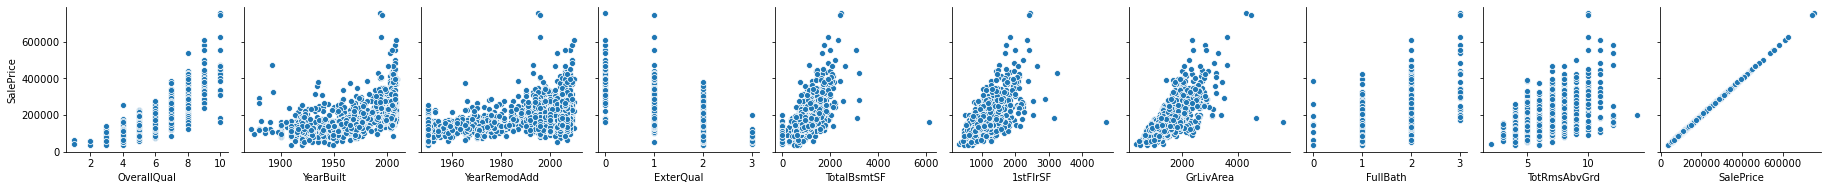

In [77]:
#Se hara una gráfica de "pairplot" para visualizar la correlación entre las variables del dataframe y la variable "SalePrice" (El precio de venta de la propiedad)
corr_viz = sns.pairplot(data=df, x_vars=df.columns, y_vars=['SalePrice'])

In [78]:
#En todas las variables se puede vislumbrar una relación positiva (excepto para la variable "ExterQual" [variable que evalúa la calidad del material en el exterior de la propiedad]) clara con la variable del precio de venta de la propiedad. Se analizará individualmente la relación entre cada una de las 9 variables y la variable del precio de la propiedad para revisar que esta relación sea estadísticamente significativa.


# 1) Relación entre "OverallQual" y "SalePrice"

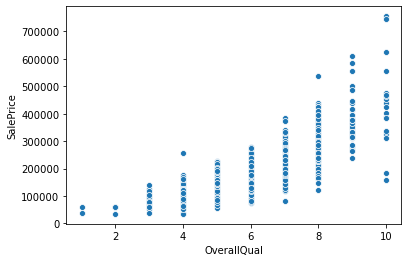

In [79]:
#La variable "OverallQual" hace referencia a la calificación del material general y el acabado general de la casa, donde la variable toma valores que van de 1 a 10, siendo 1=muy pobre y 10= más que excelente. 
sns.scatterplot(data=df, x="OverallQual", y="SalePrice")

In [80]:
#En la gráfica se observa que mientras aumenta la calificación del material y acabado de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df.OverallQual)
Y=df.SalePrice

In [81]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2437.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.19e-313
Time:                        19:09:34   Log-Likelihood:                -17827.
No. Observations:                1460   AIC:                         3.566e+04
Df Residuals:                    1458   BIC:                         3.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.621e+04   5756.407    -16.713      

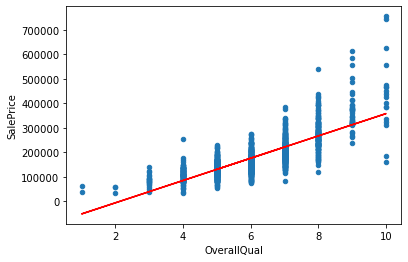

In [82]:
#En los resultados de la regresión se observa que la variable "OverallQual" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (OverallQual) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (16.713).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('OverallQual','SalePrice',kind='scatter')
plt.plot(df.OverallQual,-96210+45440*df.OverallQual, color="red")

# 2) Relación entre "YearBuilt" y "SalePrice"

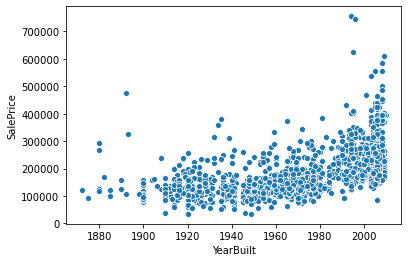

In [83]:
#La variable "YearBuilt" hace referencia al año de construcción original de la propiedad.
sns.scatterplot(data=df, x="YearBuilt", y="SalePrice")

In [84]:
#En la gráfica se observa que mientras aumenta el año en que fue construida la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df.YearBuilt)
Y=df.SalePrice

In [85]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     548.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.99e-103
Time:                        19:09:36   Log-Likelihood:                -18311.
No. Observations:                1460   AIC:                         3.663e+04
Df Residuals:                    1458   BIC:                         3.664e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.53e+06   1.16e+05    -21.858      0.0

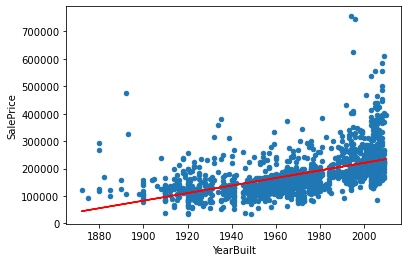

In [86]:
#En los resultados de la regresión se observa que la variable "YearBuilt" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (YearBuilt) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (23.424).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('YearBuilt','SalePrice',kind='scatter')
plt.plot(df.YearBuilt,-2530000+1375.3735*df.YearBuilt, color="red")

# 3) Relación entre "YearRemodAdd" y "SalePrice"

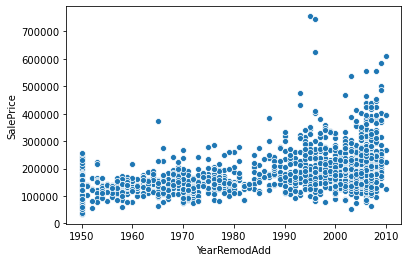

In [87]:
#La variable "YearRemodAdd" hace referencia al año de remodelación de la propiedad.
sns.scatterplot(data=df, x="YearRemodAdd", y="SalePrice")

In [88]:
#En la gráfica se observa que mientras aumenta el año en que se llevo acabo la remodelación de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df.YearRemodAdd)
Y=df.SalePrice

In [89]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     504.7
Date:                Wed, 27 Jan 2021   Prob (F-statistic):           3.16e-96
Time:                        19:09:39   Log-Likelihood:                -18327.
No. Observations:                1460   AIC:                         3.666e+04
Df Residuals:                    1458   BIC:                         3.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.692e+06   1.72e+05    -21.415   

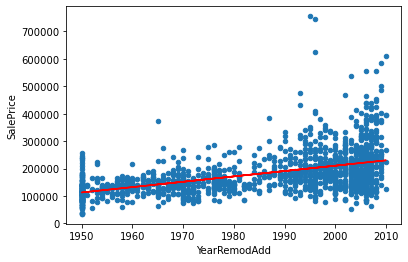

In [90]:
#En los resultados de la regresión se observa que la variable "YearRemodAdd" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (YearRemodAdd) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (22.466).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('YearRemodAdd','SalePrice',kind='scatter')
plt.plot(df.YearRemodAdd,-3692000+1951.2994*df.YearRemodAdd, color="red")

# 4) Relación entre "ExterQual" y "SalePrice"

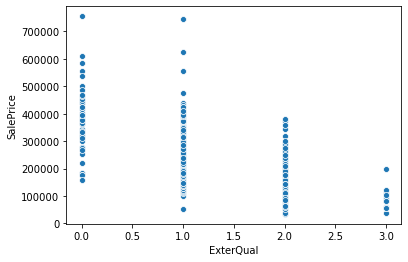

In [91]:
#La variable "ExterQual" evalúa la calidad del material en el exterior de la propiedad. En donde 0 es excelente, 1 es bueno, 2 es promedio, 3 es justo y 4 es pobre. 
sns.scatterplot(data=df, x="ExterQual", y="SalePrice")

In [92]:
#En la gráfica se observa que mientras más bueno es el material exterior de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df.ExterQual)
Y=df.SalePrice

In [93]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     1272.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          7.33e-201
Time:                        19:09:43   Log-Likelihood:                -18086.
No. Observations:                1460   AIC:                         3.618e+04
Df Residuals:                    1458   BIC:                         3.619e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.324e+05   4510.517     73.695      0.0

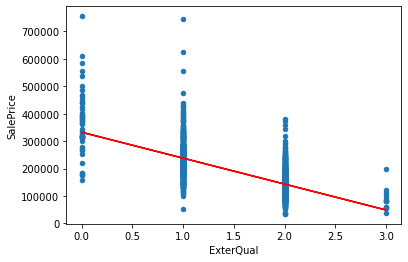

In [94]:
#En los resultados de la regresión se observa que la variable "ExterQual" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (ExterQual) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (35.670).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('ExterQual','SalePrice',kind='scatter')
plt.plot(df.ExterQual,332400-94430*df.ExterQual, color="red")

# 5) Relación entre "TotalBsmtSF" y "SalePrice"

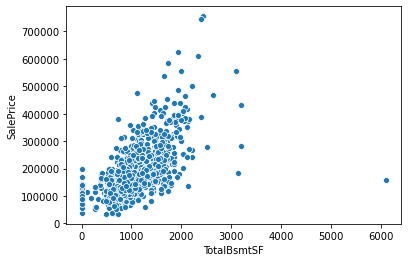

In [95]:
#La variable "TotalBsmtSF" hace referencia a la cantidad de pies cuadrados totales del área del sótano.
sns.scatterplot(data=df, x="TotalBsmtSF", y="SalePrice")

In [96]:
#En la gráfica se observa que mientras aumenta la cantidad del tamaño del área del sótano de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df.TotalBsmtSF)
Y=df.SalePrice

In [97]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     880.3
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          9.48e-152
Time:                        19:09:46   Log-Likelihood:                -18199.
No. Observations:                1460   AIC:                         3.640e+04
Df Residuals:                    1458   BIC:                         3.641e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.343e+04   4286.892     14.796      

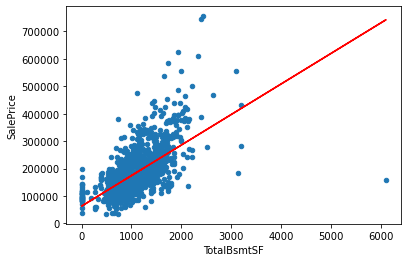

In [98]:
#En los resultados de la regresión se observa que la variable "TotalBsmtSF" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (TotalBsmtSF) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (29.671).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('TotalBsmtSF','SalePrice',kind='scatter')
plt.plot(df.TotalBsmtSF,63430+111.1096*df.TotalBsmtSF, color="red")

# 6) Relación entre "1stFlrSF" y "SalePrice"

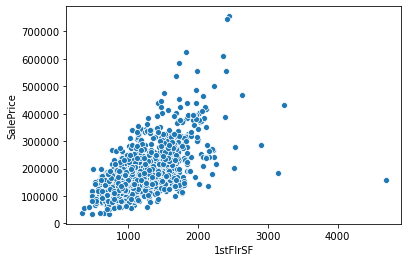

In [99]:
#La variable "1stFlrSF" hace referencia a la calificación del material general y el acabado general de la casa, donde la variable toma valores que van de 1 a 10, siendo 1=muy pobre y 10= más que excelente. 
sns.scatterplot(data=df, x="1stFlrSF", y="SalePrice")

In [100]:
#En la gráfica se observa que mientras aumenta la calificación del material y acabado de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df['1stFlrSF'])
Y=df.SalePrice

In [101]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     845.5
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          5.39e-147
Time:                        19:09:49   Log-Likelihood:                -18210.
No. Observations:                1460   AIC:                         3.642e+04
Df Residuals:                    1458   BIC:                         3.643e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.617e+04   5245.728      6.896      0.0

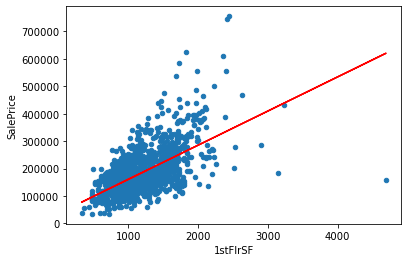

In [102]:
#En los resultados de la regresión se observa que la variable "1stFlrSF" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (1stFlrSF) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (29.078).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('1stFlrSF','SalePrice',kind='scatter')
plt.plot(df['1stFlrSF'],36170+124.5006*df['1stFlrSF'], color="red")

# 7) Relación entre "GrLivArea" y "SalePrice"

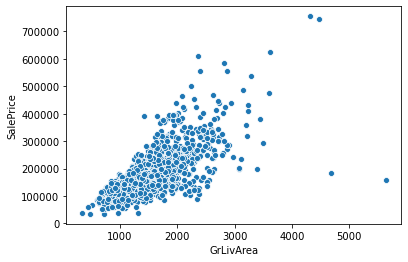

In [103]:
#La variable "GrLivArea" hace referencia a la superficie habitable sobre el nivel de suelo en pies cuadrados.
sns.scatterplot(data=df, x="GrLivArea", y="SalePrice")

In [104]:
#En la gráfica se observa que mientras aumenta la superficie habitable sobre el nive de suelo de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df['GrLivArea'])
Y=df.SalePrice

In [105]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     1471.
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          4.52e-223
Time:                        19:09:53   Log-Likelihood:                -18035.
No. Observations:                1460   AIC:                         3.607e+04
Df Residuals:                    1458   BIC:                         3.608e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.857e+04   4480.755      4.144      0.0

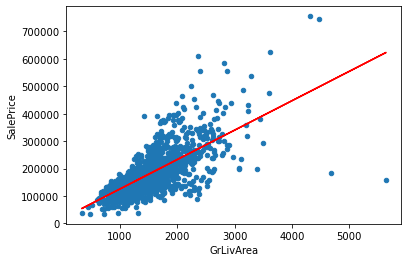

In [106]:
#En los resultados de la regresión se observa que la variable "GrLivArea" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (GrLivArea) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (38.348).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('GrLivArea','SalePrice',kind='scatter')
plt.plot(df['GrLivArea'],18570+107.1304*df['GrLivArea'], color="red")

# 8) Relación entre "FullBath" y "SalePrice"

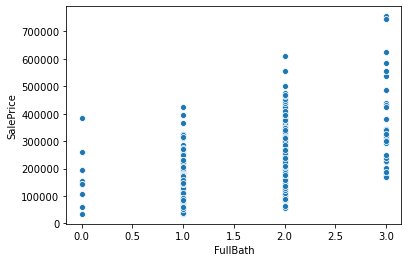

In [107]:
#La variable "FullBath" hace referencia a la la cantidad de baños completos que tiene la propiedad.
sns.scatterplot(data=df, x="FullBath", y="SalePrice")

In [108]:
#En la gráfica se observa que mientras aumenta la cantidad de baños completos de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df['FullBath'])
Y=df.SalePrice

In [109]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     668.4
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          1.24e-121
Time:                        19:09:56   Log-Likelihood:                -18269.
No. Observations:                1460   AIC:                         3.654e+04
Df Residuals:                    1458   BIC:                         3.655e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.439e+04   5188.295     10.483      0.0

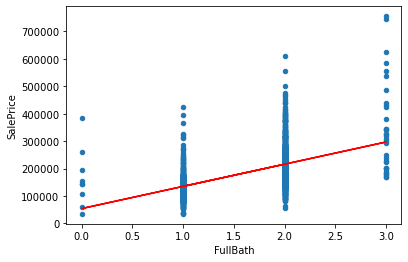

In [110]:
#En los resultados de la regresión se observa que la variable "FullBath" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (FullBath) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (25.854).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('FullBath','SalePrice',kind='scatter')
plt.plot(df['FullBath'],54390+80850*df['FullBath'], color="red")

# 9) Relación entre "TotRmsAbvGrd" y "SalePrice"

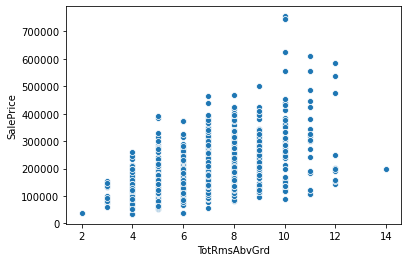

In [111]:
#La variable "TotRmsAbvGrd" hace referencia a la cantidad de cuertos totales que tiene la propiedad.
sns.scatterplot(data=df, x="TotRmsAbvGrd", y="SalePrice")

In [112]:
#En la gráfica se observa que mientras aumenta la cantidad de cuartos totales de la propiedad, más grande es el valor del precio de venta de la propiedad.
#Se procede a realizar un regresión de mínimos cuadrados ordinarios para encontrar la relación lineal entre las dos variables.
X=sm.add_constant(df['TotRmsAbvGrd'])
Y=df.SalePrice

In [113]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     580.8
Date:                Wed, 27 Jan 2021   Prob (F-statistic):          2.77e-108
Time:                        19:10:00   Log-Likelihood:                -18299.
No. Observations:                1460   AIC:                         3.660e+04
Df Residuals:                    1458   BIC:                         3.661e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.09e+04   7271.180      1.499   

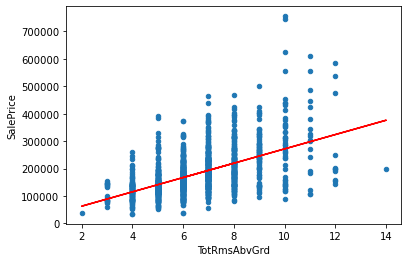

In [114]:
#En los resultados de la regresión se observa que la variable "TotRmsAbvGrd" es estadísticamente significativa para explicar la variable dependiente (SalePrice - el precio de venta de la propiedad). Esto lo sabemos porque la hipótesis nula de la prueba "t" es que la variable explicativa (TotRmsAbvGrd) es igual cero, pero en este caso se rechaza la hipótesis nula porque el p-value del estadístico "t" es menor a 0.05 y el valor del estádistico t en valor absoluto es relativamente grande (24.099).
#Se realiza el gráfico de dispersión junto con la línea que se pronóstica en el modelo a partir de los variables encontrados de la constante y el coeficiente de la variable explicativa.
df.plot('TotRmsAbvGrd','SalePrice',kind='scatter')
plt.plot(df['TotRmsAbvGrd'],10900+26090*df['TotRmsAbvGrd'], color="red")

# 10) Modelo de regresión múltiple con todas las variables para explicar "SalePrice"

In [115]:
#Se procede a realizar un regresión múltiple con las 9 variables que quedaron estadísticamente significativas en lo individual, para ver si en el modelo que incluye a todas siguen siendo estadísticamente significativas.
X=sm.add_constant(df[['OverallQual','YearBuilt','YearRemodAdd','ExterQual','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd']])
Y=df.SalePrice

In [116]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     545.8
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:10:02   Log-Likelihood:                -17465.
No. Observations:                1460   AIC:                         3.495e+04
Df Residuals:                    1450   BIC:                         3.500e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.016e+06   1.38e+05     -7.362   

In [117]:
#Se observa que todas las variables quedan estadísticamente significativas, con excepción de "TotRmsAbvGrd" que hace referencia al total de cuartos con los que cuenta la propiedad. Esto porque el estádistico "t" de esta variable queda con un valor pequeño (0.423) y el p-value es mayor a 0.05. Por lo tanto no se rechaza la hipótesis nula que el coeficiente de esta variable (TotRmsAbvGrd) es igual a cero. 

# 11) Modelo de regresión múltiple quitando las variables que no fueron significativas en la regresión anterior para explicar "SalePrice"

In [118]:
##Se procede a realizar un regresión múltiple con las 8 variables que quedaron estadísticamente significativas de la regresión anterior, para ver si en el modelo que incluye a las 8 variables siguen siendo estadísticamente significativas.
X=sm.add_constant(df[['OverallQual','YearBuilt','YearRemodAdd','ExterQual','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath']])
Y=df.SalePrice

In [119]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     614.3
Date:                Wed, 27 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:10:05   Log-Likelihood:                -17465.
No. Observations:                1460   AIC:                         3.495e+04
Df Residuals:                    1451   BIC:                         3.499e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.011e+06   1.37e+05     -7.355   

In [120]:
#Se observa que todas las variables incluídas en este último modelo son estadísticamente significativas. Esto porque todos los valores del estádistico "t" de las 8 variables son relativamente grandes y sus p-values son menor a 0.05. La R^2 ajustada tiene un valor relativamente alto (0.771) lo que indica que el modelo armado es bueno para explicar a la variable dependiente (SalePrice -  el precio de venta de la propiedad). El estadístico "F" es relativamente alto (614.3) lo que indica que por lo menos una variable de las incluídas en el modelo explica a la variable dependiente, además su p-value es menor a 0.05 por lo que se rechaza la hipótesis nula de la prueba "F" de que todas las variables explicativas son igual a cero. Si comparamos el valor "BIC" de este modelo (3.499e+04) con respecto el volor "BIC" del modelo construido en el numeral (10) con 9 variables explicativas ( 3.500e+04) se observa que es menor, lo que indica que este último modelo es mejor para explicar la variable dependiente. 
#Se pasó de tener un dataframe original con 81 variables a tener un dataframe final con 10 variables. De estas 10 variables, una es la variable explicada o dependiente (SalePrice - Precio de venta de la propiedad) y las otras 9 son las variables explicativas o independientes. En el modelo de regresión múltiple, el mejor modelo fue el que cuenta sólo con 8 variables explicativas para determinar el precio de venta de las propiedades. 